# Key notes

1. Most modern industrial controlllers are model based, so good performance calls for a high-quality process model. It is a standard practice to continuously monitor system performance and initiate a remedial model re-identification exercise in the event of performance degradation. Re-identification is particularly complicated for multivariable processes, which require a model for every input-output combination.
2. Most classical controllers in industry are linear and nonadaptive. The difficulty of learning (or estimating) reliable multivariable models in an online fashion is partly responsible for this situation. Other contributing factors include the presence of hidden states, process dimensionality, and in some cases computational complexity.
3. Purpose: New design that can learn the control policy for discrete-time nonlinear stochastic processes in real time, in a model-free and adaptive environment.
4. Hamilton-Jacobi-Bellman (HJB) equation
   It is a partial differential euqation that arises in optimal control theory. It describes the value function of an optimal control problem, which represents the minimum cost to go from a given state to a target state. The HJB equation is fundamental in dynamic programming and is used to find the optimal policy for controlling a system. The solution to the HJB equation provides the optimal control policy that minimizes the total cost over time.
   In mathematical form, the HJB equation for a continuous-time control problem is given by:
   $$
\frac{\partial V}{\partial t} + \min_u \left[ L(x,u) + \frac{\partial V}{\partial x} f(x,u) \right] = 0$$
$
$


5. Two innovations account for this latest gain in stability and robustness:
   * The network is trained off-policy with samples from a replay buffer to minimize correlations between samples, and
   * The network is trained with a target Q-network to give consistent targets during TD backups.
6. This article proposes an off-policy actor-critic algorithm, referred to as a DRL controller, for controlling of discrete-time nonlinear processes. The proposed DRL controller is a model-free controller designed based on TD learning. As a data-based controller, the DRL controller uses two independent deep neural networks to generalize the actor and critic to continuous state and action spaces. The DRL controller is based on the deterministic policy gradient (DPG) algorithm that combines an actor-critic method with insights from DQN.
7. the RL problem is a sequential decision-making problem, in which the aggent incrementallly learns how to optimally interact with the environment by maximizing the expected reward it receives.
8. Actor-critic architecture:
   actor-critic methods generalize to continuous spaces, while the issue of large variance is countered by bootstrapping, such as Q-learning with TD update. A schematic of the actor-critic architecture:
   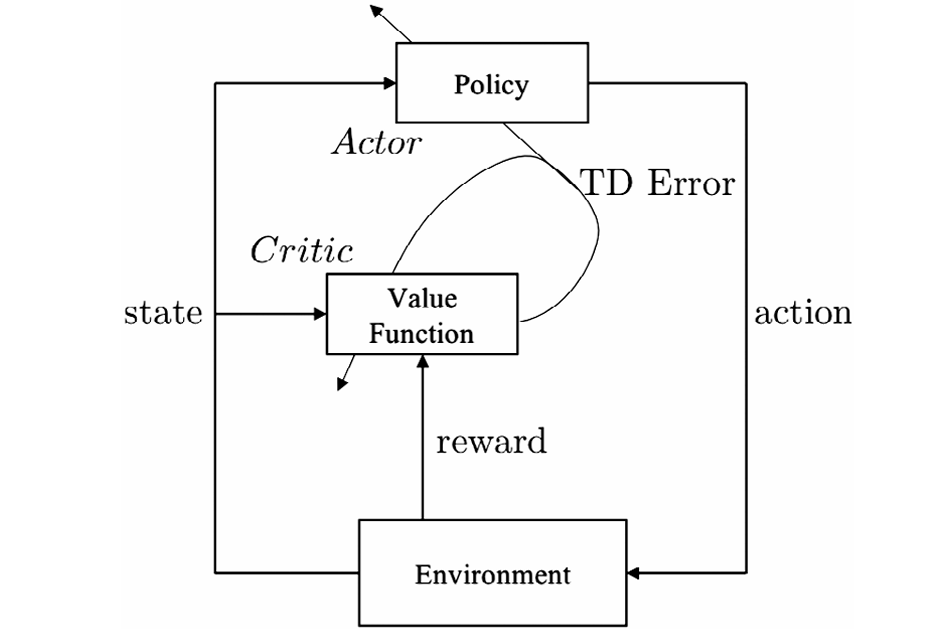
   The actor-critic architecture consists of two eponymous components: an actor that finds an optimal policy and a critic that evaluates the current policy prescribed by the actor. The actor implements the policy gradient method by adjusting policy parameters using SGA. The critic approximates the Q-function using an FA.
9. While the actor-critic method combines the policy gradient with Q-learning, the policy is not directly inferred from Q-learning. Instead, the policy is updated in the policy gradient direction. This avoids the costly optimization in Q-learning, and also ensures that changes in the Q-function only result in small changes in policy, leading to less or no oscillatory behavior in the policy. Finally, under certain conditions, local optimal policy convergence is guaranteed.
10. For simplicity, we focus on the case where the output consists of full information on the state of the system to be controlled. Removing this hypothesis is an important practical element of ongoing research in this area.
11. In contrast with MPC, where the controller minimizes the tracking error over the space of control actions, here the agent maximizes the reward it receives over the space of policies. We consider two reward functions.
    * An $\ell_{1}$ reward function measures the negative $\ell_{1}$-norm of the tracking error.
    * A polar reward function: assigns a 0 reward if the tracking error is a monotonically decreasing function at each sampling time for all $n_y$ outputs or -1 otherwise. Observe that a polar reward incentivizes gradual improvements in tracking performance, which leads to less aggressive control strategy and a smoother tracking compared with the $\ell_{1}$-reward. $


12. Learning control policies
    In the proposed DRL controller architecture, the actor is represented by $\mu (s_t, W_a)$ and a critic is represented by $Q(s_t, a_t, W_c)$.
    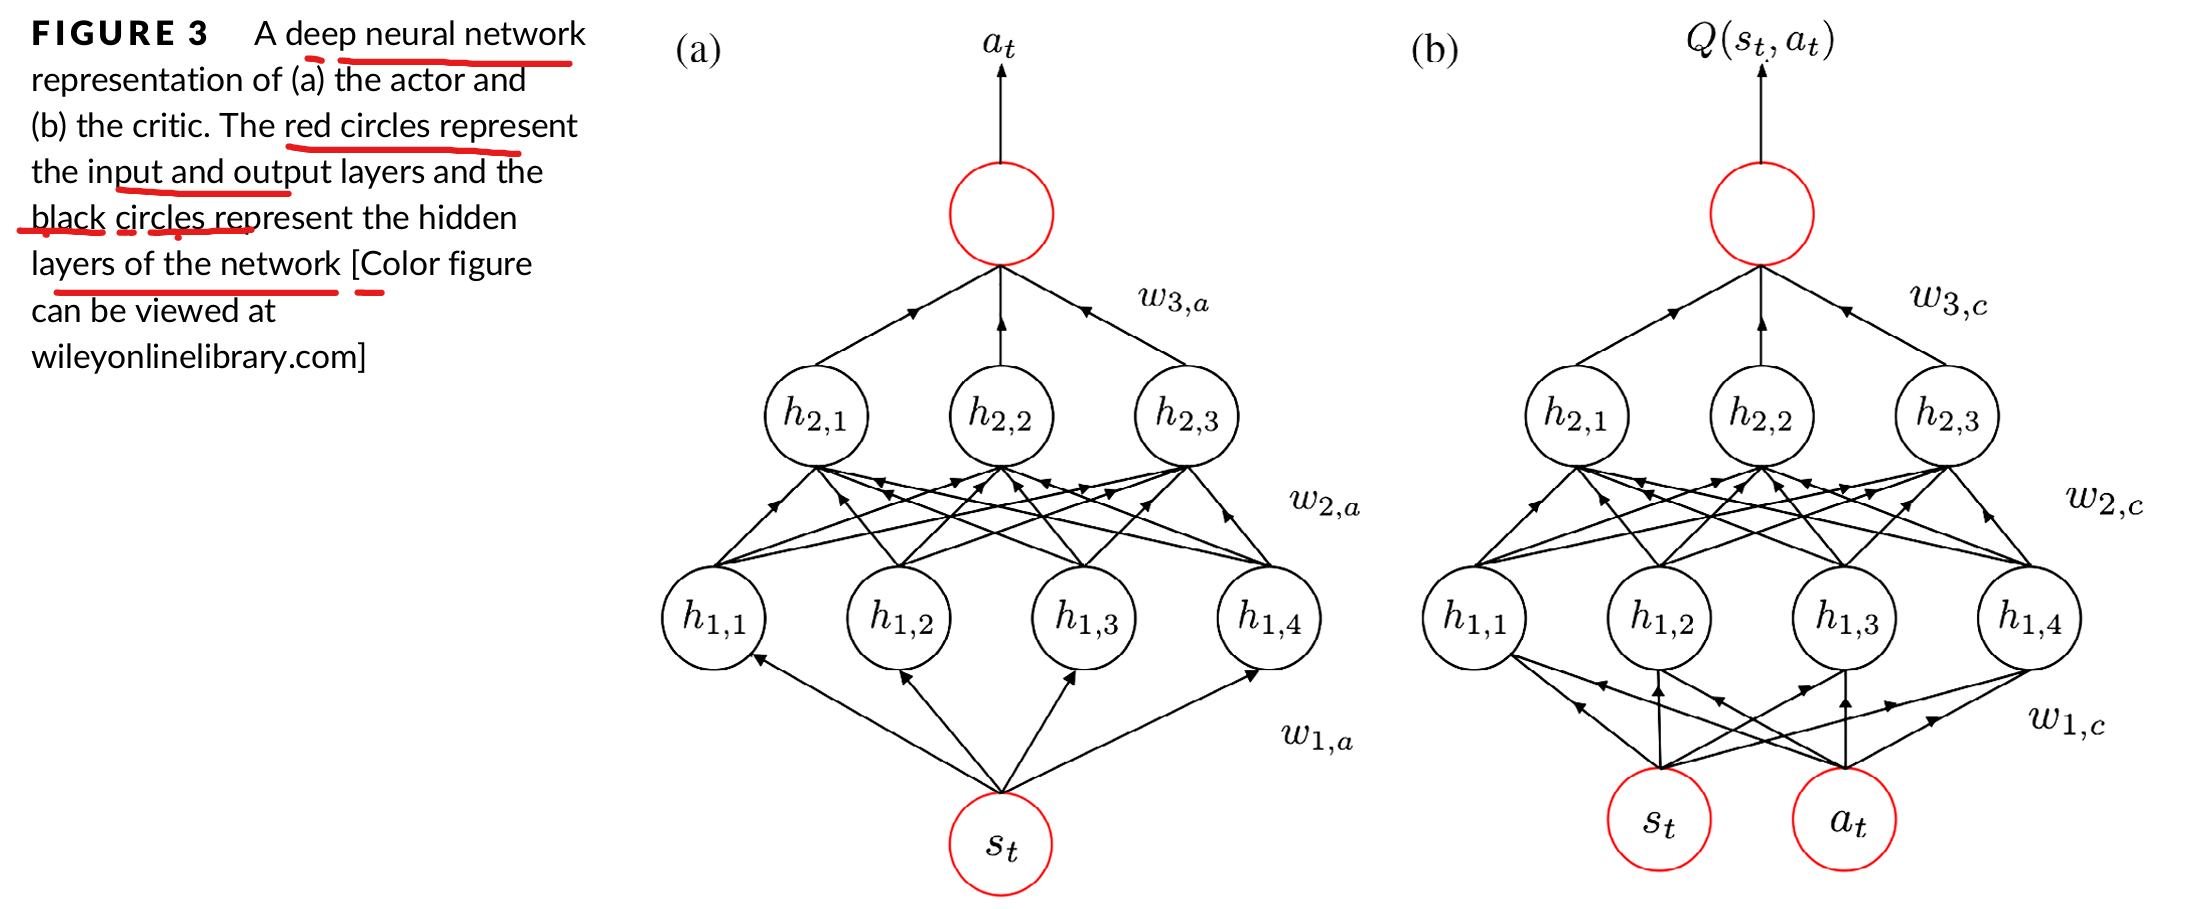
    The critic network predicts Q-values for each state-action pair, and the actor network proposes an action for a given state. The goal is then to learn the actor and critic neural network parameters by interacting with the process plant. Once the networks are trained, the actor network is used to compute the optimal action for any given state.
    To make learning more effective for dynamic systems, we propose to break the inherent temporal correlations between the tuples by randomizing it. To this effect, we use a batch SGD, rather than a single sample SGD for network training. As in DQN, we use a replay memory (RM) for batch training of the networks. As a queue data structure, the latest tuples are always stored in the RM, and the old tuples are discarded to keep the cache size constant. At each time, the network is updated by uniformly sampling $M(M<=K)$ tuples from the RM.
    Another strategy to further stabilize the actor-critic architecture. Propose to use a separarte network, called target network, to estimate the target. The target values change slowing, thereby improving the stability of learning. A similar target network can also be used for stabilizing the actor network.
    It is also important to bound the network over the feasible action space. One approach to enforce the constraints on the network is to bound the output layer of the actor network. This is done by clipping the gradients used by the actor network in the update step.
    

## Algorithm 5 Deep RL Controller

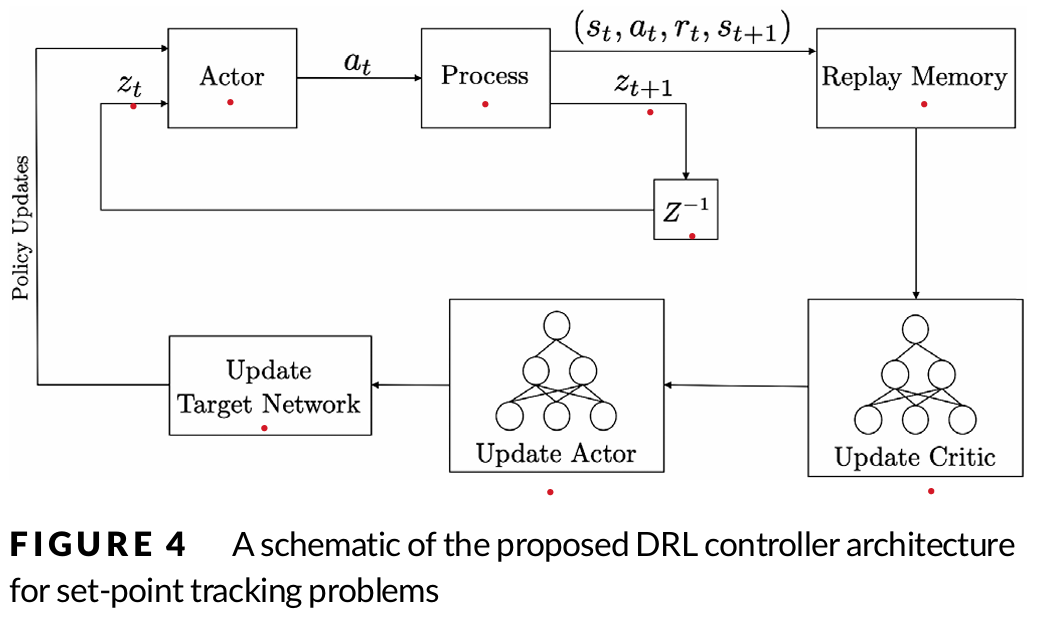

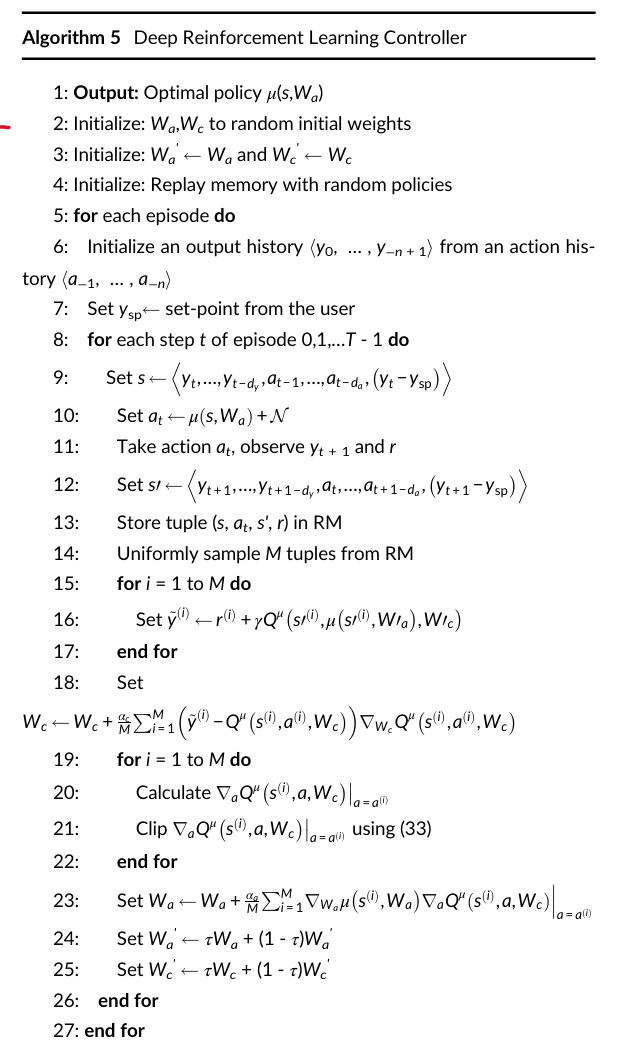

1. Initialization:
   * Initialize the actor and critic networks with random weights
   * Create copies of these networks to serve as target networks
   * Initialize a replay memory (RM) with random policies
2. Episode setup:
   * For each episode, initialize the output history and action history
   * Set the desired set-point from the user
3. Main Loop:
   * For each time step within the episode
     * Define the state $s_t$ based on current and past outputs, past actions, and the current deviation from the set-point
     * Compute the action $a_t$ using the actor network and add exploration noise
     * Apply the action to the process and observe the new output and reward
     * Define the next state $s_{t+1}$ based on the new observations
     * Store the tuple $(s_t, a_t, s_{t+1}, r_t)$ in the replay memory

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random

# ------------------------------
# Paper Machine Env (unchanged)
# ------------------------------
class PaperMachineEnv:
    def __init__(self):
        self.state = 0.0  # Initial moisture content
        self.action_space = [0, 100]  # Action bounds
        self.output_space = [0, 10]   # Output (moisture) bounds
        self.a = 0.6  # Process coefficient
        self.b = 0.05 # Process coefficient
        self.set_point = 0.0  # Set point for tracking

    def reset(self):
        self.state = np.random.uniform(*self.output_space)
        return self.state  # environment just returns single float y_t

    def step(self, action):
        action = np.clip(action, *self.action_space)
        next_state = self.a * self.state + self.b * action
        reward = -abs(next_state - self.set_point)  # negative of tracking error
        self.state = next_state
        done = False  # We'll override in the loop after certain steps
        return self.state, reward, done, {}

# ---------------
# OU Process
# ---------------
class OUProcess:
    def __init__(self, size, mu=0.0, theta=0.15, sigma=0.2):
        self.size = size
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        self.state = np.ones(self.size) * self.mu

    def noise(self):
        dx = self.theta * (self.mu - self.state)
        dx += self.sigma * np.random.randn(self.size)
        self.state += dx
        return self.state

# ------------------------------
# Actor and Critic Networks
# ------------------------------
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden1=400, hidden2=300):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, action_dim)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, state):
        x = self.relu(self.fc1(state))
        x = self.relu(self.fc2(x))
        # Output in [-1,1], which we'll map to [0,100] outside
        return self.tanh(self.fc3(x))

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden1=400, hidden2=300):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, 1)
        self.relu = nn.ReLU()

    def forward(self, state, action):
        # state: shape [batch_size, state_dim]
        # action: shape [batch_size, action_dim]
        x = torch.cat([state, action], dim=1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

# ------------------------------
# Replay Buffer
# ------------------------------
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

# ------------------------------
# Deep RL Controller (DDPG)
# ------------------------------
class DeepRLController:
    def __init__(
        self,
        state_dim,
        action_dim,
        action_bounds,
        actor_lr=1e-4,
        critic_lr=1e-3,
        gamma=0.99,
        tau=0.005,
        buffer_size=100000,
        batch_size=64
    ):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.action_bounds = action_bounds  # [min_action, max_action]
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size

        # Actor
        self.actor = Actor(state_dim, action_dim)
        self.actor_target = Actor(state_dim, action_dim)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)

        # Critic
        self.critic = Critic(state_dim, action_dim)
        self.critic_target = Critic(state_dim, action_dim)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)

        # Replay buffer
        self.replay_buffer = ReplayBuffer(buffer_size)

        # Noise process
        self.noise = OUProcess(size=action_dim)

    def select_action(self, state, explore=True):
        """
        state: 1D numpy array, shape [state_dim].
        Returns a float action in [0,100] (or self.action_bounds).
        """
        state_t = torch.FloatTensor(state).unsqueeze(0)  # shape [1, state_dim]
        with torch.no_grad():
            raw_a = self.actor(state_t).numpy()[0]  # shape [action_dim], in [-1,1]
        if explore:
            raw_a += self.noise.noise()  # add OU noise
        raw_a = np.clip(raw_a, -1.0, 1.0)
        # map [-1,1] -> [min_action, max_action]
        min_a, max_a = self.action_bounds
        scaled_a = (raw_a + 1.0) * 0.5 * (max_a - min_a) + min_a
        return scaled_a

    def train_step(self):
        if len(self.replay_buffer) < self.batch_size:
            return  # not enough data

        batch = self.replay_buffer.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states)      # shape [B, state_dim]
        actions = torch.FloatTensor(actions)    # shape [B, action_dim]
        rewards = torch.FloatTensor(rewards).unsqueeze(1)  # shape [B,1]
        next_states = torch.FloatTensor(next_states)       # shape [B, state_dim]
        dones = torch.FloatTensor(dones).unsqueeze(1)      # shape [B,1]

        # ----- Critic update -----
        with torch.no_grad():
            next_actions = self.actor_target(next_states)
            target_q = self.critic_target(next_states, next_actions)
            target_q = rewards + self.gamma * (1.0 - dones) * target_q
        current_q = self.critic(states, actions)
        critic_loss = nn.MSELoss()(current_q, target_q)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        # simple gradient clip for critic
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 10.0)
        self.critic_optimizer.step()

        # ----- Actor update -----
        # Because the actor is deterministic, we do -Q(s, mu(s))
        actor_loss = -self.critic(states, self.actor(states)).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        # simple gradient clip for actor
        torch.nn.utils.clip_grad_norm_(self.actor.parameters(), 10.0)
        self.actor_optimizer.step()

        # ----- Soft update targets -----
        self.soft_update(self.actor, self.actor_target)
        self.soft_update(self.critic, self.critic_target)

    def soft_update(self, source_net, target_net):
        for tp, sp in zip(target_net.parameters(), source_net.parameters()):
            tp.data.copy_(self.tau * sp.data + (1 - self.tau) * tp.data)

    def add_to_buffer(self, state, action, reward, next_state, done):
        self.replay_buffer.add(state, action, reward, next_state, done)

# ------------------------------
# Main Simulation
# ------------------------------
def simulate_paper_machine():
    # Suppose we want d_y=2, d_a=2, so total state_dim = d_y + d_a + 1 extra for (y_t - sp)
    # We'll store them externally in a small queue for each episode.

    d_y = 2
    d_a = 2
    env = PaperMachineEnv()
    
    # The final state vector length = d_y + d_a + 1
    # (the +1 is for (y_t - y_sp)).
    state_dim = d_y + d_a + 1
    action_dim = 1
    action_bounds = [0, 100]

    controller = DeepRLController(
        state_dim=state_dim,
        action_dim=action_dim,
        action_bounds=action_bounds,
        actor_lr=1e-4,
        critic_lr=1e-3,
        gamma=0.99,
        tau=0.005,
        buffer_size=100000,
        batch_size=64
    )

    episodes = 500
    max_steps_per_episode = 200
    warmup_steps = 1000  # random actions for the first 1000 steps

    rewards_history = []
    global_step_count = 0

    for ep in range(episodes):
        y_t = env.reset()
        env.set_point = np.random.uniform(*env.output_space)

        # We store the last d_y outputs and last d_a actions
        y_queue = deque([y_t]*d_y, maxlen=d_y)  # init with current y
        a_queue = deque([0.0]*d_a, maxlen=d_a)  # start with 0 action

        # Construct initial "augmented state"
        # s_0 = [y_t, y_{t-1}, ..., a_{t-1}, (y_t - sp)]
        def build_state():
            # Flatten y_queue + a_queue + (y_t - sp)
            return np.concatenate([
                np.array(y_queue),
                np.array(a_queue),
                np.array([y_queue[0] - env.set_point])  # current y - sp
            ])

        state = build_state()
        controller.noise.reset()

        episode_reward = 0.0

        for step in range(max_steps_per_episode):
            global_step_count += 1

            # --- Action selection ---
            if global_step_count < warmup_steps:
                # random exploration
                action = np.random.uniform(action_bounds[0], action_bounds[1], size=(1,))
            else:
                action = controller.select_action(state, explore=True)

            # --- Environment step ---
            next_y, reward, done, _ = env.step(action)
            episode_reward += reward

            # Build next state
            y_queue.appendleft(next_y)  # y_{t+1} at front
            a_queue.appendleft(action[0])  # store the single scalar action
            next_state = build_state()

            # Mark done if this is the last step in the episode
            done_flag = (step == max_steps_per_episode - 1)

            # Store in replay
            controller.add_to_buffer(
                state, 
                action, 
                reward, 
                next_state, 
                done_flag
            )

            # Training step
            controller.train_step()

            # Move on
            state = next_state
            if done_flag:
                break

        rewards_history.append(episode_reward)

    # Plot results
    plt.plot(rewards_history)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("DDPG Training on PaperMachineEnv")
    plt.show()

if __name__ == "__main__":
    simulate_paper_machine()


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.